# Forecasting model using Prophet
# https://facebook.github.io/prophet/docs/quick_start.html#python-api

## update: that shi dont work lol


In [3]:
# import stuff
import pandas as pd
import matplotlib.pyplot as plt


# Data


In [4]:
df = pd.read_csv('data_g/data_time_vehicles.csv')
# convert timestamp from milliseconds to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
# normalize data
df['vehicle'] = df['vehicle'] / df['vehicle'].max()
df.head()

,timestamp,vehicle
0,2022-06-17 17:00:00,0.565047
1,2022-06-17 18:00:00,0.010609
2,2022-06-21 00:00:00,0.077610
3,2022-06-21 16:00:00,0.266332
4,2022-06-21 17:00:00,0.754886


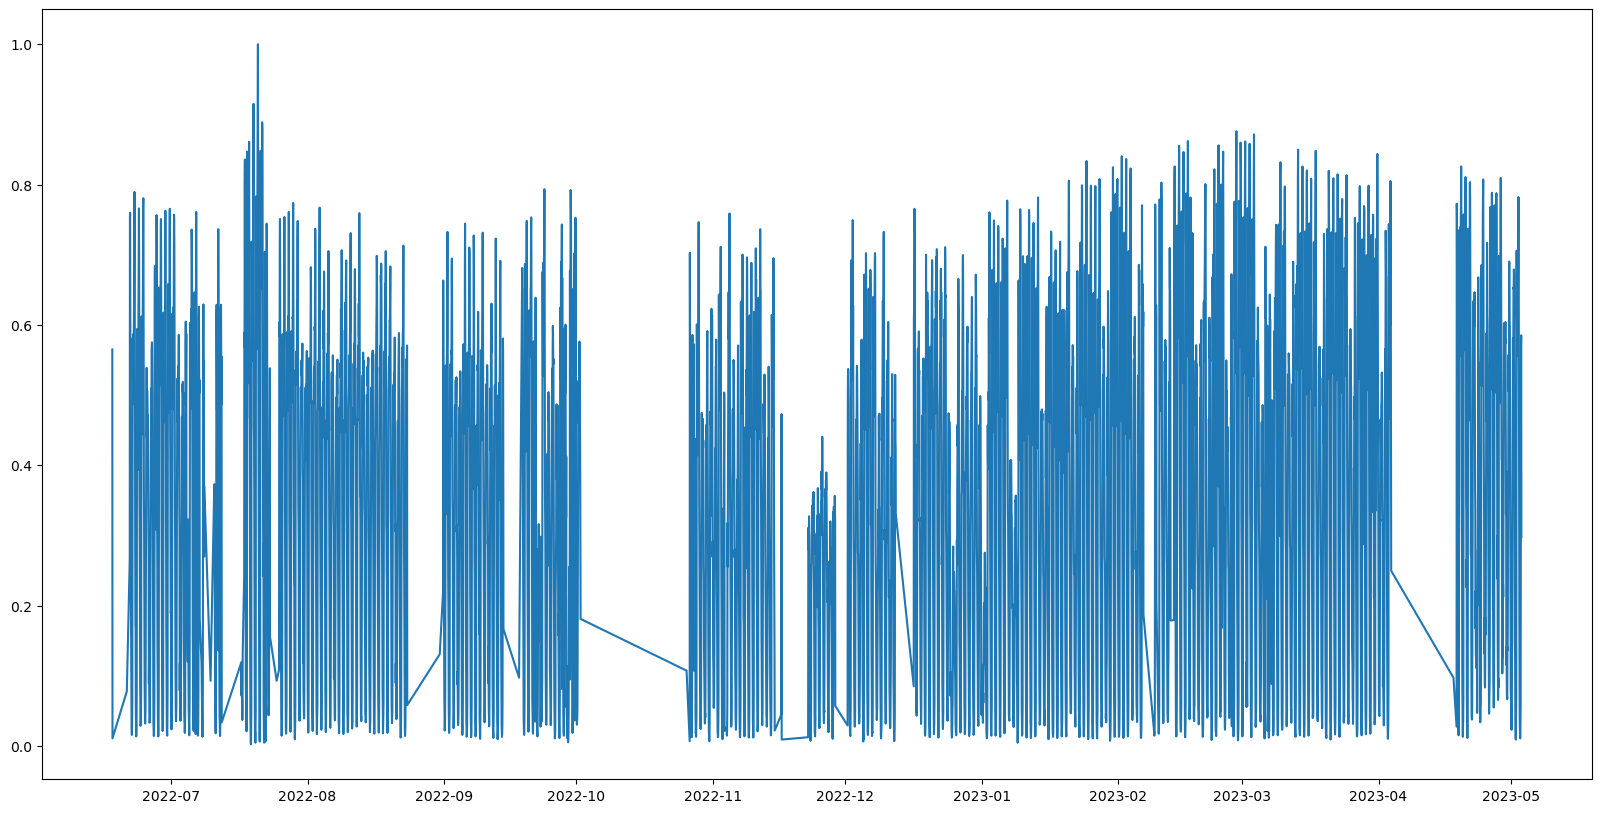

In [5]:
# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['timestamp'], df['vehicle'])
plt.show()

In [ ]:
from fancyimpute import IterativeImputer

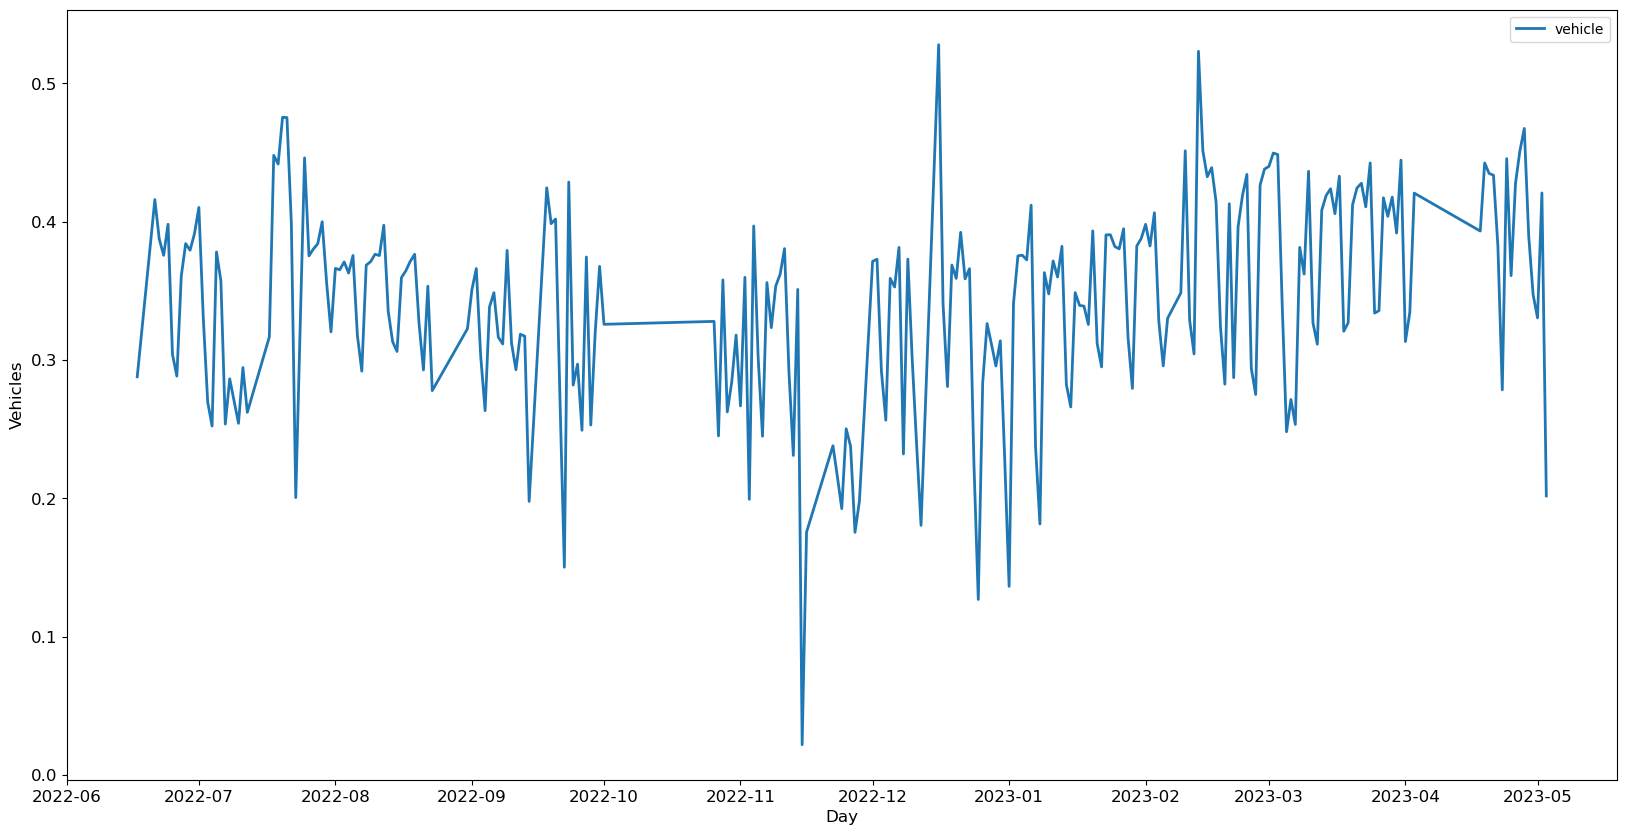

In [6]:
# plotting by days (mean)
dd = df.groupby([df['timestamp'].dt.date]).mean()
dd.plot(figsize=(20,10), linewidth=2, fontsize=12)
plt.xlabel('Day', fontsize=12);
plt.ylabel('Vehicles', fontsize=12);
plt.show()      

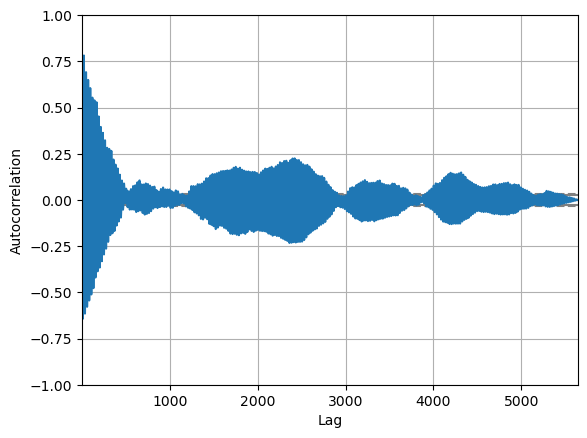

In [13]:
from pandas.plotting import autocorrelation_plot

# plotting autocorrelation from all data
autocorrelation_plot(df['vehicle'])
plt.show()

### plot before and after MICE

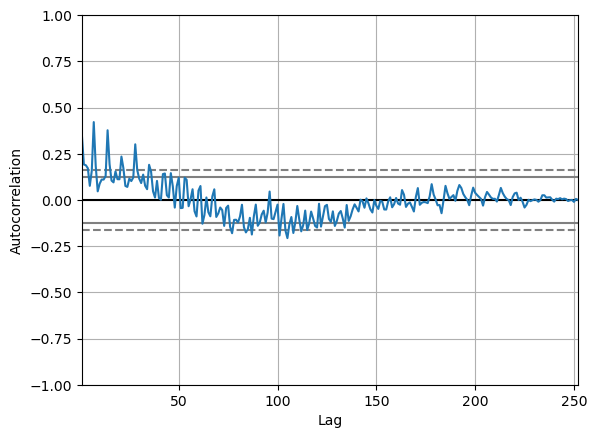

In [11]:
from pandas.plotting import autocorrelation_plot

# plotting autocorrelation
autocorrelation_plot(dd)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21868\2383129225.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('data_g/data_time_vehicles.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                vehicle   No. Observations:                 5643
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -37587.006
Date:                Wed, 17 May 2023   AIC                          75186.012
Time:                        11:38:09   BIC                          75225.840
Sample:                             0   HQIC                         75199.886
                               - 5643                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3496      0.007     48.621      0.000       0.336       0.364
ar.L2         -0.1086      0.010    -10.357      0.000      -0.129      -0.088
ar.L3         -0.0075      0.013     -0.577      0.5

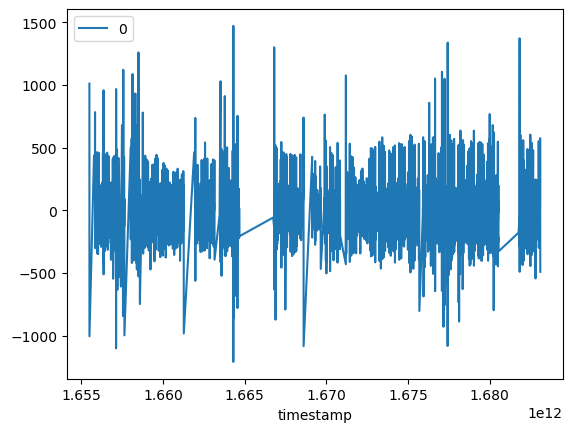

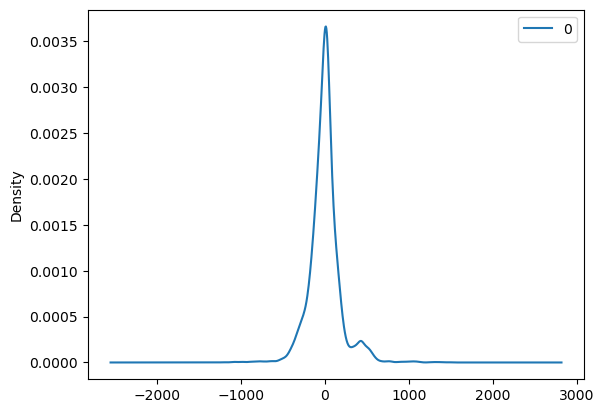

                 0
count  5643.000000
mean      0.102990
std     189.779014
min   -1210.178816
25%     -87.677629
50%       0.090998
75%      66.626914
max    1472.491674


In [51]:
from statsmodels.tsa.arima.model import ARIMA

series = pd.read_csv('data_g/data_time_vehicles.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.head()

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

for ts: 2022-06-17 17:00:00, predicted=1113.449879, expected=995.000000
for ts: 2022-06-17 18:00:00, predicted=932.670501, expected=1146.000000
for ts: 2022-06-21 00:00:00, predicted=1198.804906, expected=1107.000000
for ts: 2022-06-21 16:00:00, predicted=1096.660810, expected=1227.000000
for ts: 2022-06-21 17:00:00, predicted=1263.241658, expected=1447.000000
for ts: 2022-06-21 18:00:00, predicted=1522.203017, expected=1493.000000
for ts: 2022-06-21 19:00:00, predicted=1486.596448, expected=1100.000000
for ts: 2022-06-21 20:00:00, predicted=972.313433, expected=814.000000
for ts: 2022-06-21 21:00:00, predicted=767.167222, expected=522.000000
for ts: 2022-06-21 22:00:00, predicted=459.178678, expected=365.000000
for ts: 2022-06-21 23:00:00, predicted=310.746997, expected=243.000000
for ts: 2022-06-22 00:00:00, predicted=196.645075, expected=159.000000
for ts: 2022-06-22 01:00:00, predicted=119.946012, expected=62.000000
for ts: 2022-06-22 02:00:00, predicted=25.452200, expected=38.0000

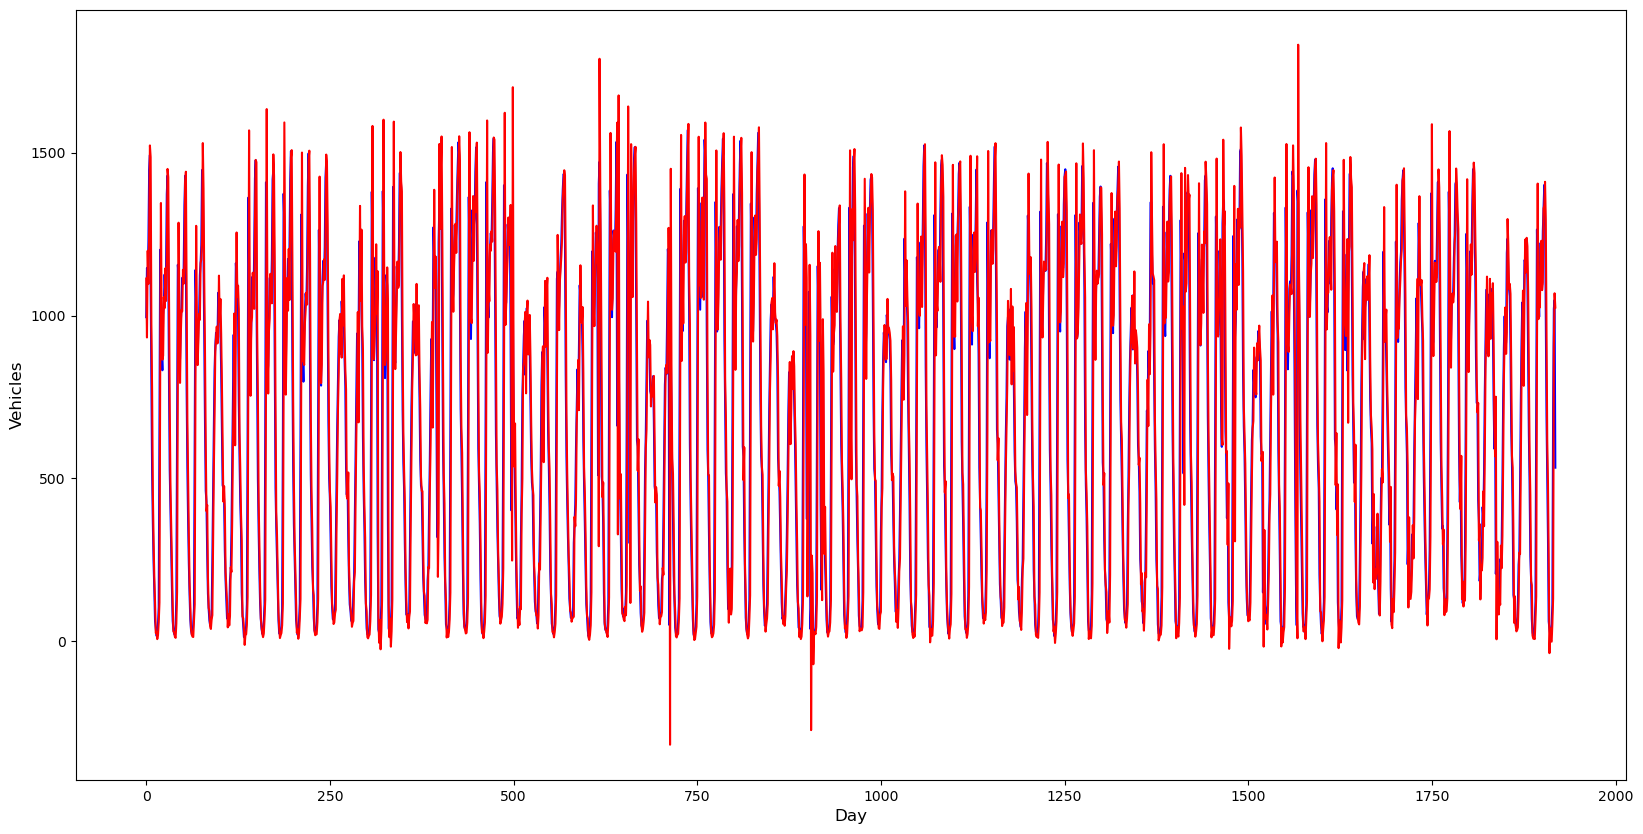

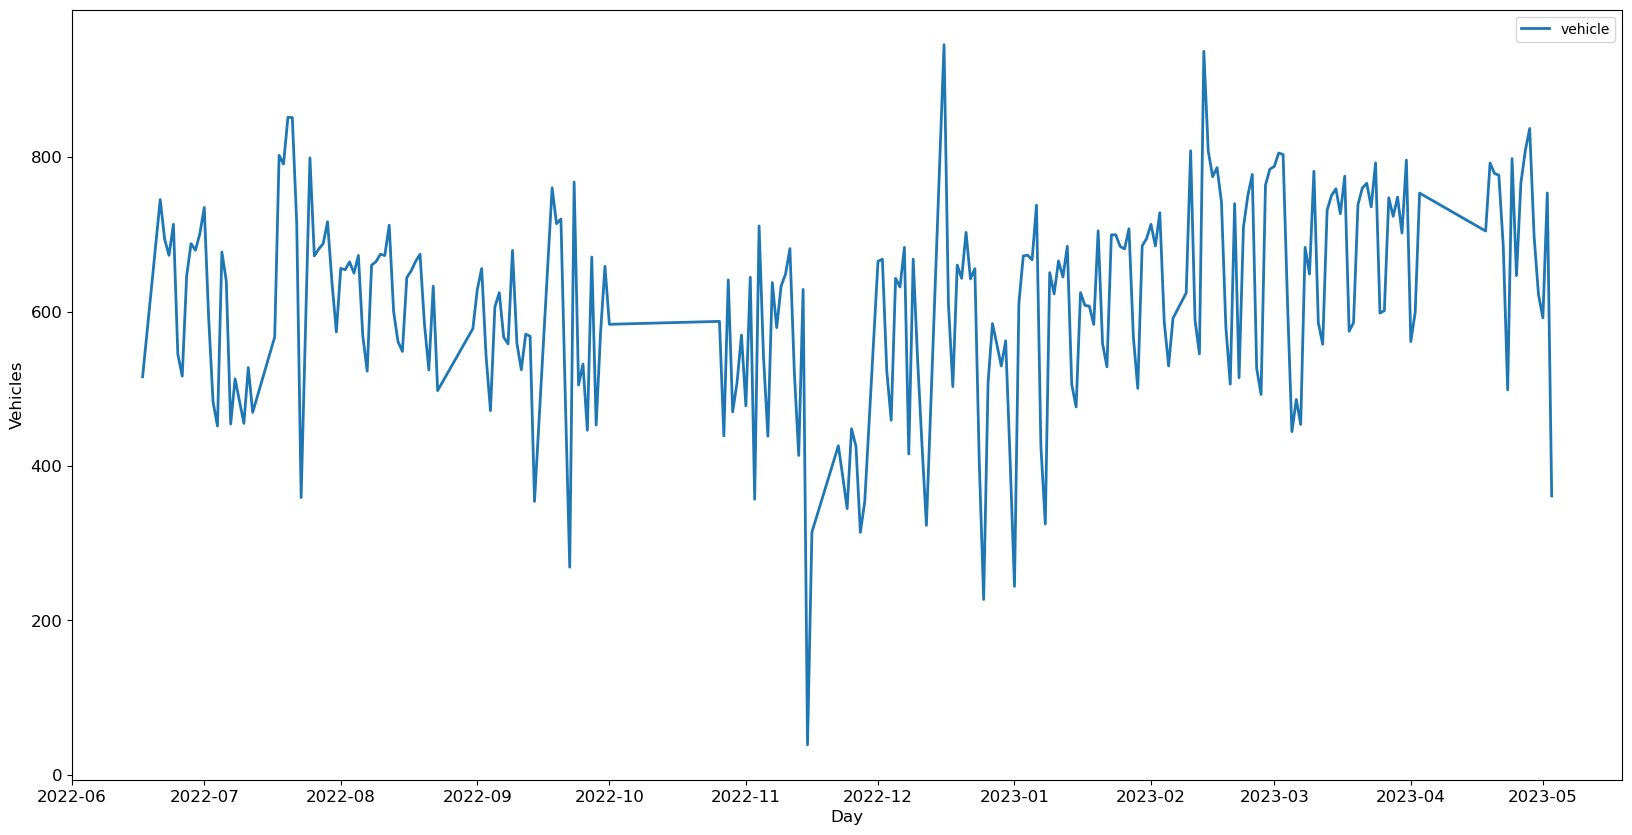

In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []


# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # convert timestamp from milliseconds to datetime
    day = pd.to_datetime(df['timestamp'], unit='ms')
    print('for ts: %s, predicted=%f, true=%f' % (day[t], yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.figure(figsize=(20,10))
plt.plot(test, color='blue')
plt.plot(predictions, color='red')
plt.xlabel('Day', fontsize=12);
plt.ylabel('Vehicles', fontsize=12);
plt.show()

''' # plotting by days (mean)
dd = df.groupby([df['timestamp'].dt.date]).mean()
dd.plot(figsize=(20,10), linewidth=2, fontsize=12)
plt.xlabel('Day', fontsize=12);
plt.ylabel('Vehicles', fontsize=12);
plt.show() '''



[61.0, 38.0, 20.0, 19.0, 51.0, 114.0, 707.0, 1021.0, 1048.0, 533.0]

In [ ]:

y_pred = pd.Series(model_fit.forecast(steps=24)[0], index=pd.date_range(start='2022-10-01 17:00:00', periods=24, freq='H'))
y_true = model_fit.predict(start='2022-10-01 17:00:00', end='2022-10-02 16:00:00', dynamic=True)

In [ ]:
# now we can predict the next day hourly
# create list of timestamps for the next day (24 hours)
from datetime import datetime, timedelta

# 1st timestamp : 1684281600000
# get 23 next timestamps
ts = 1684281600000
ts_list = []
for i in range(23):
    ts_list.append(ts)
    ts += 3600000

# convert timestamps to datetime
ts_list = [datetime.fromtimestamp(ts/1000) for ts in ts_list]

# predict the next day
predictions = []
for t in range(len(ts_list)):
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    # what does output[0] mean?
    # output[0] is the predicted value
    # and output[1] is the standard error of the prediction
    
    predictions.append(yhat)
    history.append(yhat)
    print('for ts: %s, predicted=%f' % (ts_list[t], yhat))

# plot predictions
plt.figure(figsize=(20,10))
plt.plot(predictions, color='red')
plt.xlabel('Hour', fontsize=12);
plt.ylabel('Vehicles', fontsize=12);
plt.show()


